# Analysis of Preprint Papers from the ArXiv

The website [arxiv.org](https://arxiv.org) is a popular database for scientific papers in STEM fields. ArXiv has its own classification system consisting of roughly 150 different categories, which are manually added by the authors whenever a new paper is uploaded. A paper can be assigned multiple categories.

The goal for this project is to develop a machine learning model which can predict the ArXiv category from a given title and abstract. The data set used here has been scraped from the [ArXiv API](https://arxiv.org/help/api) over several days, using the Python scraper `arxiv_scraper.py`.

To get a sense for how long the scraping takes, you can uncomment and run the script below.

In [1]:
#from arxiv_scraper import cat_scrape
#cat_scrape(
#    max_results_per_cat = 100, # maximum number of papers to download per category (there are ~150 categories)
#    file_path = "arxiv_data", # name of output file
#    batch_size = 100 # size of every batch - lower batch size requires less memory - must be less than 30,000
#)

Alternatively, I have downloaded metadata from about a million papers using this scraper (with `max_results_per_cat` = 10000), which can be freely downloaded below. This data set takes up ~1gb of space, however, so I've included many random samples of this data set as well:

* `arxiv` contains the main data set
* `arxiv_sample_1000` contains 1,000 papers
* `arxiv_sample_5000` contains 5,000 papers
* `arxiv_sample_10000` contains 10,000 papers
* `arxiv_sample_25000` contains 25,000 papers
* `arxiv_sample_50000` contains 50,000 papers
* `arxiv_sample_100000` contains 100,000 papers
* `arxiv_sample_200000` contains 200,000 papers
* `arxiv_sample_500000` contains 500,000 papers
* `arxiv_sample_750000` contains 750,000 papers

Choose your favorite below. Alternatively, of course, you can set it to be the file name of your own scraped data.

In [2]:
file_name = "arxiv_sample_10000"

We start by importing all the packages we will need and setting up a data directory.

In [3]:
# base packages
import pandas as pd
import numpy as np

# plot packages
import matplotlib.pyplot as plt
import seaborn as sns

# handling files
import os
import wget # downloading files
import tarfile # dealing with compressed .tar.gz files
import pickle # enables saving data and models locally

# other stuff
import re # regular expressions
import spacy as sp # used for lemmatising text
from sklearn.decomposition import PCA # dimension reduction of data

os.system("mkdir data") # create data directory

print("Packages loaded and data directory created.")

Packages loaded and data directory created.


## Fetching data

We then download the chosen data set --- if you've already scraped your own data set then skip this stage.

In [4]:
url_start = f"https://filedn.com/lRBwPhPxgV74tO0rDoe8SpH/scholarly_data/"

# download the paper data
if not os.path.isfile(f'data/{file_name}.csv'):
    print(f"Downloading {file_name}.csv...", end = " ")
    wget.download(url_start + f"{file_name}.csv", out = f"data/{file_name}.csv")
    print("Done!")
else:
    print(f"{file_name}.csv already downloaded.")

arxiv_sample_10000.csv already downloaded.


Next, we download a list of all the arXiv categories and store them in `cats`.

In [5]:
# download a list of all the arXiv categories
if not os.path.isfile('data/cats.csv'):
    print("Downloading cats.csv...", end = " ")
    wget.download(url_start + "cats.csv", out = "data/cats.csv")
    print("Done!")
else:
    print("cats.csv already downloaded.")

# construct category dataframe and array
cats_df = pd.read_csv("data/cats.csv")
cats = np.asarray(cats_df['category'].values)

pd.set_option('display.max_colwidth', 50)
cats_df.head()

cats.csv already downloaded.


,category,description
0,astro-ph,Astrophysics
1,astro-ph.CO,Cosmology and Nongalactic Astrophysics
2,astro-ph.EP,Earth and Planetary Astrophysics
3,astro-ph.GA,Astrophysics of Galaxies
4,astro-ph.HE,High Energy Astrophysical Phenomena


Next up we load the data into a dataframe. This might take a little while.

In [6]:
def nan_if_empty(x):
    ''' Converts empty lists/arrays to NaNs, making it easier to detect by pandas. '''
    arr = np.asarray(x)
    if arr.size == 0:
        return np.nan
    else:
        return arr

def remove_non_cats(x):
    ''' Removes every string in x which does not occur in the list of arXiv categories. '''
    return np.intersect1d(np.asarray(x), cats)

def str_to_arr(x):
    ''' Converts a string to a numpy array. '''
    return np.asarray(re.sub('[\' \[\]]', '', x).split(','))

def clean_cats(x):
    ''' Composition of nan_if_empty, remove_non_cats and str_to_arr. Used to clean scraped data. '''
    return nan_if_empty(remove_non_cats(str_to_arr(x)))

In [7]:
# set up dataframe
df = pd.read_csv(f'data/{file_name}.csv', converters={'category': clean_cats})[['title', 'abstract', 'category']]

print(f"Loaded metadata from {df.shape[0]} papers. Here are some of them:")
pd.set_option('display.max_colwidth', 300)
df.sample(3)

Loaded metadata from 10000 papers. Here are some of them:


,title,abstract,category
9251,"Caldeira-Leggett Model, Landau Damping, and the Vlasov-Poisson System","The Caldeira-Leggett Hamiltonian (Eq. (1) below) describes the interaction of\na discrete harmonic oscillator with a continuous bath of harmonic oscillators.\nThis system is a standard model of dissipation in macroscopic low temperature\nphysics, and has applications to superconductors, quantu...","[math-ph, math.MP, physics.plasm-ph, quant-ph]"
1360,Data-adaptive estimation of time-varying spectral densities,"This paper introduces a data-adaptive non-parametric approach for the\nestimation of time-varying spectral densities from nonstationary time series.\nTime-varying spectral densities are commonly estimated by local kernel\nsmoothing. The performance of these nonparametric estimators, however, d...","[stat.CO, stat.ME]"
7519,A Minimalistic Approach to Segregation in Robot Swarms,"We present a decentralized algorithm to achieve segregation into an arbitrary\nnumber of groups with swarms of autonomous robots. The distinguishing feature\nof our approach is in the minimalistic assumptions on which it is based.\nSpecifically, we assume that (i) Each robot is equipped with a...",[cs.RO]


## Cleaning the data

We next do some basic cleaning of the data.

In [8]:
df_clean = df.copy()

# drop rows with NaNs
df_clean.dropna(inplace = True)

# merge title and abstract
df_clean['clean_text'] = df_clean['title'] + ' ' + df_clean['abstract']

# remove punctuation marks
punctuation ='\!\"\#\$\%\&\(\)\*\+\-\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~'
df_clean['clean_text'] = df_clean['clean_text'].apply(lambda x: re.sub(punctuation, '', x))

# convert text to lowercase
df_clean['clean_text'] = df_clean['clean_text'].str.lower()

# remove numbers
df_clean['clean_text'] = df_clean['clean_text'].str.replace("[0-9]", " ")

# remove whitespaces
df_clean['clean_text'] = df_clean['clean_text'].apply(lambda x:' '.join(x.split()))

print(f"Shape of df_clean: {df_clean.shape}")
pd.set_option('display.max_colwidth', 300)
df_clean[['title', 'abstract', 'clean_text']].head()

Shape of df_clean: (10000, 4)


,title,abstract,clean_text
0,"Staggered fermions, zero modes, and flavor-singlet mesons","We examine the taste structure of eigenvectors of the staggered-fermion Dirac\noperator. We derive a set of conditions on the eigenvectors of modes with small\neigenvalues (near-zero modes), such that staggered fermions reproduce the 't\nHooft vertex in the continuum limit. We also show that, ...","staggered fermions, zero modes, and flavor-singlet mesons we examine the taste structure of eigenvectors of the staggered-fermion dirac operator. we derive a set of conditions on the eigenvectors of modes with small eigenvalues (near-zero modes), such that staggered fermions reproduce the 't hoo..."
1,PhyNetLab: An IoT-Based Warehouse Testbed,Future warehouses will be made of modular embedded entities with\ncommunication ability and energy aware operation attached to the traditional\nmaterials handling and warehousing objects. This advancement is mainly to\nfulfill the flexibility and scalability needs of the emerging warehouses.\n...,phynetlab: an iot-based warehouse testbed future warehouses will be made of modular embedded entities with communication ability and energy aware operation attached to the traditional materials handling and warehousing objects. this advancement is mainly to fulfill the flexibility and scalabilit...
2,Geometry of nonadiabatic quantum hydrodynamics,"The Hamiltonian action of a Lie group on a symplectic manifold induces a\nmomentum map generalizing Noether's conserved quantity occurring in the case of\na symmetry group. Then, when a Hamiltonian function can be written in terms of\nthis momentum map, the Hamiltonian is called `collective'. ...","geometry of nonadiabatic quantum hydrodynamics the hamiltonian action of a lie group on a symplectic manifold induces a momentum map generalizing noether's conserved quantity occurring in the case of a symmetry group. then, when a hamiltonian function can be written in terms of this momentum map..."
3,E2E-MLT - an Unconstrained End-to-End Method for Multi-Language Scene\n Text,An end-to-end trainable (fully differentiable) method for multi-language\nscene text localization and recognition is proposed. The approach is based on a\nsingle fully convolutional network (FCN) with shared layers for both tasks.\n E2E-MLT is the first published multi-language OCR for scene ...,e e-mlt - an unconstrained end-to-end method for multi-language scene text an end-to-end trainable (fully differentiable) method for multi-language scene text localization and recognition is proposed. the approach is based on a single fully convolutional network (fcn) with shared layers for both...
4,State of the Practice in Software Effort Estimation: A Survey and\n Literature Review,"Effort estimation is a key factor for software project success, defined as\ndelivering software of agreed quality and functionality within schedule and\nbudget. Traditionally, effort estimation has been used for planning and\ntracking project resources. Effort estimation methods founded on tho...","state of the practice in software effort estimation: a survey and literature review effort estimation is a key factor for software project success, defined as delivering software of agreed quality and functionality within schedule and budget. traditionally, effort estimation has been used for pl..."


Our last text cleaning step is to lemmatise the text, which reduces all words to its base form. For instance, 'eating' is converted into 'eat' and 'better' is converted into 'good'. This usually takes a while to finish, so instead we're simply going to download a lemmatised version of your chosen data set. Alternatively, if you're dealing with your own scraped data set, you can uncomment the marked lines below.

In [9]:
def lemmatise(texts):
    ''' Lemmatise an iterable of strings. '''
    
    # import spacy's language model
    try:
        nlp = sp.load('en', disable=['parser', 'ner'])
    except:
        os.system("python -m spacy download en --user")
        nlp = sp.load('en', disable=['parser', 'ner']) 

    return np.asarray([' '.join(np.asarray([token.lemma_ for token in nlp(text)])) for text in texts])

In [10]:
df_lemm = df_clean.copy()

if not os.path.isfile(f"data/{file_name}_clean.csv"):
    
    #  uncomment if you want to do it the hard way, or if you're dealing with your own data set
    #df_lemm['clean_text'] = lemmatise(df_lemm['clean_text'])
    #df_lemm.to_csv(f"data/{file_name}_clean.csv")
    #print(f"Finished lemmatising, and also saved lemmatised dataframe to data/{file_name}_clean.csv.")
    
    # download lemmatised dataframe
    print(f"Downloading {file_name}_clean.csv...", end = " ")
    wget.download(url_start + f"{file_name}_clean.csv", out = f"data/{file_name}_clean.csv")
    print("Done!")
    
# load lemmatised dataframe
df_lemm['clean_text'] = pd.read_csv(f"data/{file_name}_clean.csv")
df_lemm.dropna(inplace = True)
print(f"Loaded lemmatised data from data/{file_name}_clean.csv.")

print(f"Shape of df_lemm: {df_lemm.shape}. Here are some of the lemmatised texts:")
pd.set_option('display.max_colwidth', 1000)
df_lemm[['clean_text']].head()

Loaded lemmatised data from data/arxiv_sample_10000_clean.csv.
Shape of df_lemm: (9898, 4). Here are some of the lemmatised texts:


,clean_text
0,"e e - mlt - an unconstrained end - to - end method for multi - language scene text an end - to - end trainable ( fully differentiable ) method for multi - language scene text localization and recognition be propose . the approach be base on a single fully convolutional network ( fcn ) with share layer for both task . e e - mlt be the first publish multi - language ocr for scene text . while train in multi - language setup , e e - mlt demonstrate competitive performance when compare to other method train for english scene text alone . the experiment show that obtain accurate multi - language multi - script annotation be a challenging problem ."
1,"state of the practice in software effort estimation : a survey and literature review effort estimation be a key factor for software project success , define as deliver software of agree quality and functionality within schedule and budget . traditionally , effort estimation have be use for planning and tracking project resource . effort estimation method found on those goal typically focus on provide exact estimate and usually do not support objective that have recently become important within the software industry , such as systematic and reliable analysis of causal effort dependency . this article present the result of a study of software effort estimation from an industrial perspective . the study survey industrial objective , the ability of software organization to apply certain estimation method , and actually apply practice of software effort estimation . finally , requirement for effort estimation method identify in the survey be compare against exist estimation method ."
2,"momentum - resolve radio - frequency spectroscopy of ultracold atomic fermi gas in a spin - orbit couple lattice -PRON- investigate theoretically momentum - resolve radio - frequency ( rf ) spectroscopy of a noninteracte atomic fermi gas in a spin - orbit couple lattice . this lattice configuration have be recently create at mit [ cheuk et al . , arxiv : . ] for li atom , by couple the two hyperfine spin - state with a pair of raman laser beam and additional rf coupling . here , -PRON- show that momentum - resolve rf spectroscopy can measure single - particle energy and eigenstate and therefore resolve the band structure of the spin - orbit couple lattice . in -PRON- calculation , -PRON- take into account the effect of temperature and harmonic trap . -PRON- prediction be to be confront with future experiment on spin - orbit couple fermi gas of k atom in a lattice potential ."
3,"solution of laplace 's equation with simple boundary condition , and -PRON- application for capacitor with multiple symmetry -PRON- find solution of laplace 's equation with specific boundary condition ( in which such solution take either the value zero or unity in each surface ) use a generic curvilinear system of coordinate . such purely geometrical solution ( that -PRON- shall call basic harmonic function bhf 's ) be utilize to obtain a more general class of solution for laplace 's equation , in which the function take arbitrary constant value on the boundary . on the other hand , the bhf 's be also use to obtain the capacitance of many electrostatic configuration of conductor . this method of find solution of laplace 's equation and capacitance with multiple symmetry be particularly simple , owe to the fact that the method of separation of variable become much simple under the boundary condition that lead to the bhf 's . example of application in complex symmetry be give . then..."
4,"accelerate cosmo in a non - extensive setup here , -PRON- consider a flat frw universe whose -PRON- horizon entropy meet the r\'enyi entropy of non - extensive system . in -PRON- model , the ordinary energy - momentum conservation law be not always valid . by apply the clausius relation as well as the cai - kim temperature to the apparent horizon of a flat frw universe , -PRON- obtain modify friedmann equation . fit the model to the 

## Feature extraction

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

df_vec = df_lemm.copy()
full_pickle = f"data/{file_name}_tfidf.pickle"
full_csv = f"data/{file_name}_tfidfvals.csv"

if not os.path.isfile(full_pickle) or not os.path.isfile(full_csv):
    vectorizer = TfidfVectorizer(
        strip_accents = 'unicode',
        lowercase = True,
        analyzer = "word",
        tokenizer = None, 
        preprocessor = None, 
        stop_words = 'english',
        ngram_range = (1, 3),
        max_features = 1000,
    )

    print("Training tfidf extractor...", end = " ")
    vectorizer.fit(df_vec['clean_text'])
    print("Done!")

    print("Extracting tfidf features...", end = " ")
    bag_of_words = vectorizer.transform(df_vec['clean_text']).toarray()
    print("Done!")
    
    with open(full_pickle, "wb") as pickle_out:
        pickle.dump(bag_of_words, pickle_out)
    print(f"Saved tfidf features to {full_pickle}.")
    
    tfidf = pd.DataFrame(
        index = vectorizer.vocabulary_.keys(), 
        data = vectorizer.idf_, 
        columns = ['tf-idf']
    )
    tfidf = tfidf.sort_values(by = ['tf-idf'], ascending = False)
    tfidf.to_csv(full_csv)
    print(f"Saved tfidf values to {full_csv}.")

else:
    print(f"Loading {full_pickle} and {full_csv}...", end = " ")
    with open(full_pickle, "rb") as pickle_in:
        bag_of_words = pickle.load(pickle_in)
    tfidf = pd.read_csv(full_csv)
    print("Done!")
    
df_vec = pd.DataFrame(bag_of_words).join(df_vec['category'])
df_vec = df_vec.dropna()
df_vec.head()

Loading data/arxiv_sample_10000_tfidf.pickle and data/arxiv_sample_10000_tfidfvals.csv... Done!


,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,category
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.09536,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,[hep-lat]
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,[cs.NI]
2,0.0,0.0,0.0,0.0,0.072009,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,"[math-ph, math.MP, physics.chem-ph]"
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081569,[cs.CV]
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,[cs.SE]


In [12]:
tfidf.iloc[:10]

,Unnamed: 0,tf-idf
0,science,6.192856
1,processing,6.025802
2,detect,5.995496
3,robot,5.995496
4,conjecture,5.966083
5,atomic,5.882701
6,eigenvalue,5.869456
7,exponential,5.856384
8,angular,5.856384
9,field theory,5.843480


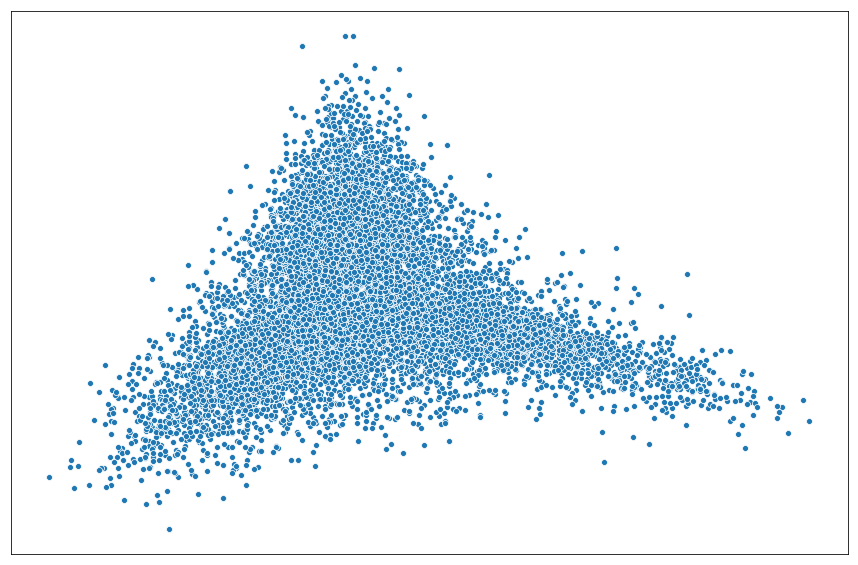

In [13]:
n = df_vec.shape[1] - 1
X = np.asarray(df_vec.iloc[:, :n])
X_2d = PCA(n_components = 2).fit_transform(X)
df_vec_2d = pd.DataFrame(X_2d, columns = ['x', 'y'])

fig, ax = plt.subplots(1, figsize = (15, 10))
ax.set_xticks([])
ax.set_yticks([])
sns.scatterplot(data = df_vec_2d, x = 'x', y = 'y')

## ELMo feature extraction

To build our model we have to extract features from the titles and abstracts. We will be using ELMo, a state-of-the-art NLP framework developed by AllenNLP, which converts text input into vectors, with similar words being closer to each other. We will first download the ELMo model. It is over 350mb in size, so it might take a little while.

We now need to extract ELMo features from our cleaned text data. This is done using the `extract` function from `elmo.py`. This usually takes a LONG time.

## One-hot encoding of categories

We then perform a one hot encoding for the category variable, as this will make training our model easier. We do this by first creating a dataframe with columns the categories and binary values for every paper, and then concatenate our original dataframe with the binary values.

## Analysis of the data

Here is how the categories in our data set are distributed.

We see that our data is not particularly uniformly distributed. These are the categories with the most amount of papers in the data set.

In [14]:
def aggregate_cat(cat):
    if cat[:8] == 'astro-ph':
        agg_cat = 'physics'
    elif cat[:2] == 'cs':
        agg_cat = 'cs'
    elif cat[:5] == 'gr-qc':
        agg_cat = 'physics'
    elif cat[:3] == 'hep':
        agg_cat = 'physics'
    elif cat[:4] == 'math':
        agg_cat = 'math'
    elif cat[:4] == 'nlin':
        agg_cat = 'physics'
    elif cat[:4] == 'nucl':
        agg_cat = 'physics'
    elif cat[:7] == 'physics':
        agg_cat = 'physics'
    elif cat[:8] == 'quant-ph':
        agg_cat = 'physics'
    elif cat[:4] == 'stat':
        agg_cat = 'stats'
    else:
        agg_cat = 'other'
    return agg_cat

def aggregate_cats(cats):
    return np.asarray([aggregate_cat(cat) for cat in cats])

In [15]:
agg_cats_df = cats_df.copy()
agg_cats_df['category'] = agg_cats_df['category'].apply(aggregate_cat)
agg_cats = np.asarray(agg_cats_df['category'].unique())
print("Aggregated categories:")
print(agg_cats)

Aggregated categories:
['physics' 'other' 'cs' 'math' 'stats']


In [16]:
def agg_cats_to_binary(categories):
    '''
    Turns aggregated categories into a 0-1 sequence with 1's at every category index.
    
    INPUT
        categories, an iterable of strings
    
    OUTPUT
        numpy array with 1 at the category indexes and zeros everywhere else
    '''
    agg_categories = aggregate_cats(categories)
    return np.in1d(agg_cats, agg_categories).astype('int8')

print("One-hot encoding...", end = " ")

df_1hot_agg = df_vec.copy()

# populate cats_df with the information from df
bincat_arr = np.array([agg_cats_to_binary(cat_list) for cat_list in df_1hot_agg['category']]).transpose()
bincat_dict = {key:value for (key,value) in zip(agg_cats, bincat_arr)}
bincat_df = pd.DataFrame.from_dict(bincat_dict)

# concatenate df with the columns in cats_df
df_1hot_agg = pd.concat([df_1hot_agg, bincat_df], axis=1, sort=False)

# drop the category column
df_1hot_agg.drop(['category'], axis=1, inplace=True)

print("Done!")

# show the new columns of the data frame
pd.set_option('display.max_colwidth', 10)
print(f"Dimensions of df_1hot: {df_1hot_agg.shape}.")
df_1hot_agg.head()

One-hot encoding... Done!
Dimensions of df_1hot: (9898, 1005).


,0,1,2,3,4,5,6,7,8,9,...,995,996,997,998,999,physics,other,cs,math,stats
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.09536,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1,0,0,0,0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0,0,1,0,0
2,0.0,0.0,0.0,0.0,0.072009,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1,0,0,1,0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.081569,0,0,1,0,0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0,0,1,0,0


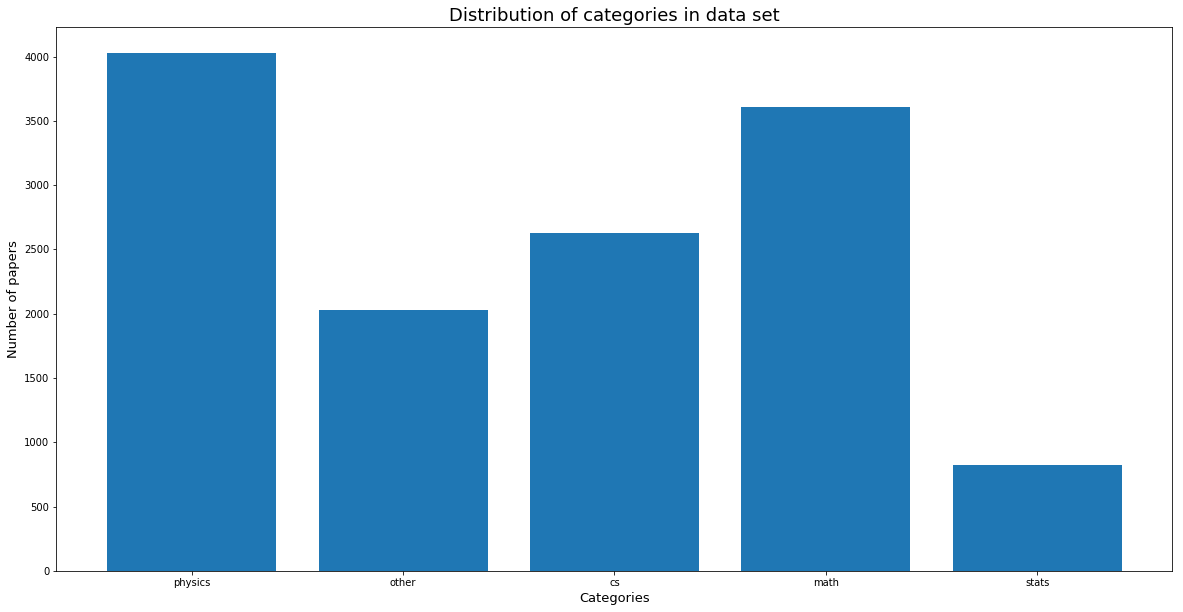

In [17]:
# save a dataframe with the amount of papers in each category
sum_cats = bincat_df.apply(lambda x: x.sum())

# plot the distribution of the amount of papers in each category
plt.figure(figsize=(20,10))
plt.bar(x=sum_cats.keys(), height=sum_cats.values)
plt.xlabel('Categories', fontsize=13)
plt.ylabel('Number of papers', fontsize=13)
plt.title('Distribution of categories in data set', fontsize=18)
plt.show()

## Choosing a model

We are now done manipulating our data, and the time has come to build a model.

In [18]:
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import hamming_loss, make_scorer, f1_score

In [19]:
n = df_vec.shape[1] - 1
X = np.asarray(df_1hot_agg.iloc[:, 0:n])
Y = np.asarray(df_1hot_agg.iloc[:, n:])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [20]:
def micro_avg_precision(Y_test, Y_hat):
    TPs = np.sum(Y_hat.multiply(Y_test).todense())
    return TPs / np.sum(Y_hat)

def micro_avg_recall(Y_test, Y_hat):
    TPs = np.sum(Y_hat.multiply(Y_test).todense())
    return TPs / np.sum(Y_test)

def micro_avg_f1(Y_test, Y_hat):
    prec = micro_avg_precision(Y_test, Y_hat)
    rec = micro_avg_recall(Y_test, Y_hat)
    return 2 * prec * rec / (prec + rec)

micro_avg_f1_score = make_scorer(micro_avg_f1)

In [21]:
print("Training model...", end = " ")
clf = MLkNN(k = 3)
clf.fit(X_train, Y_train)
print("Done!")

Training model... Done!


In [22]:
print("~~~ TRAINING DATA ~~~")
Y_hat = clf.predict(X_train)
print(f"Micro-average precision: {micro_avg_precision(Y_train, Y_hat)}")
print(f"Micro-average recall: {micro_avg_recall(Y_train, Y_hat)}")
print(f"Micro-average f1 score: {micro_avg_f1(Y_train, Y_hat)}")
print(f"MACRO-average f1 score: {f1_score(Y_train, Y_hat, average = 'macro')}")
print("")

print("~~~ TEST DATA ~~~")
Y_hat = clf.predict(X_test)
print(f"Micro-average precision: {micro_avg_precision(Y_test, Y_hat)}")
print(f"Micro-average recall: {micro_avg_recall(Y_test, Y_hat)}")
print(f"Micro-average f1 score: {micro_avg_f1(Y_test, Y_hat)}")
print(f"MACRO-average f1 score: {f1_score(Y_test, Y_hat, average = 'macro')}")

~~~ TRAINING DATA ~~~
Micro-average precision: 0.7167993297025556
Micro-average recall: 0.5225491194136211
Micro-average f1 score: 0.6044512482336316
MACRO-average f1 score: 0.5234140209791864

~~~ TEST DATA ~~~
Micro-average precision: 0.32687447346251053
Micro-average recall: 0.2355798421372192
Micro-average f1 score: 0.273817925194072
MACRO-average f1 score: 0.21346223822728527


#### Micro-average f1 scores for aggregation with `MLkNN(k = 3)` and `TfidfVectorizer(max_features = 1000)`:
* 1,000 samples:
    * Train score: 0.6072455434157562
    * Test score: 0.32055749128919864
* 5,000 samples:
    * Train score: 0.6154025399044624
    * Test score: 0.29947275922671357
* 10,000 samples:
    * Train score: 0.6023466542750929
    * Test score: 0.26957592820693294
* 25,000 samples:
    * Train score: 0.6091259190103863
    * Test score: 0.29261856815498927
* 50,000 samples:
    * Train score: 
    * Test score: 
* 100,000 samples:
    * Train score: 
    * Test score:  

#### Micro-average f1 scores for aggregation with  `MLkNN(k = 3)` and  `ELMo(batch_size = 10)`:
* 1,000 samples:
    * Train score: 0.6008182349503214
    * Test score: 0.28125
* 5,000 samples:
    * Train score: 0.6135125738787809
    * Test score: 0.27739251040221913
* 10,000 samples:
    * Train score: 0.6075919475765984
    * Test score: 0.30265920223932824
* 25,000 samples:
    * Train score: 0.6054086846956156
    * Test score: 0.2851554313657003
* 50,000 samples:
    * Train score: 
    * Test score: 
* 100,000 samples:
    * Train score: 
    * Test score:  

In [23]:
parameters = {'k': range(1,5), 's': [0.5, 0.75, 1.0]}

print("Doing a grid search...", end = " ")
grid_search = GridSearchCV(MLkNN(), parameters, scoring = micro_avg_f1_score, cv = 5)
grid_search.fit(X, Y)
print("Done!")

print(f"The best parameters are {grid_search.best_params_}")
print(f"The best score was {grid_search.best_score_}.")

Doing a grid search... Done!
The best parameters are {'k': 1, 's': 0.5}
The best score was 0.3111275375971436.


#### Grid searched micro-average f1 scores for aggregation with `MLkNN` and `TfidfVectorizer(max_features = 1000)`:
* 1,000 samples:
    * Best k: 2
    * Best s: 0.5
    * Score: 0.3873442618436344
* 5,000 samples:
    * Best k: 1
    * Best s: 0.5
    * Score: 0.3171409097332802
* 10,000 samples:
    * Best k: 1
    * Best s: 0.5
    * Score: 0.3111275375971436
* 25,000 samples:
    * Best k: 
    * Best s: 
    * Score: 
* 50,000 samples:
    * Best k: 
    * Best s: 
    * Score: 
* 100,000 samples:
    * Best k: 
    * Best s: 
    * Score: 

In [24]:
clf = grid_search.best_estimator_

with open(f"data/{file_name}_model.pickle", "wb") as pickle_out:
    pickle.dump(clf, pickle_out)